Your model will be evaluated using two metrics: profit @ top-20, and AUC. The reasons for this is to be in line with a more realistic setting. E.g. one can image data scientists in a team arguing to use AUC and optimize for that. However, as seen in the course, for this scenario, we also imagine management arguing that there is not enough budget (in terms of time and money) to contact a lot of people (or hand out a lot of promotions). Hence, they have come up with the following: based on the top-k would-be churners as predicted by your model, sum some proxy of "retained profitability" in case the customer was indeed a churner, or zero otherwise

As a proxy of profitability, the feature average cost min was deemed to be a good value. Based on the size of the test set, k=20 was deemed to be a good choice. Hence, management cares about optimizing this metric
Note that only about half of the test set is used for the "public" leaderboard. That means that the score you will see on the leaderboard is done using this part of the test only (you don't know which half). Later on through the semester, submissions are frozen and the resuls on the "hidden" part will be revealed

Also, whilst you can definitely try, the goal is not to "win", but to help you reflect on your model's results, see how others are doing, etc.

Objectives:

Some groups prefer to write their final report using Jupyter Notebook, which is fine too, as long as it is readable top-to-bottom

You can use any predictive technique/approach you want, though focus on the whole process: general setup, critical thinking, and the ability to get and validate an outcome

You're free to use unsupervised technique for your data exploration part, too. When you decide to build a black box model, including some interpretability techniques to explain it is a plus

Any other assumptions or insights are thoughts can be included as well: the idea is to take what we've seen in class, get your hands dirty and try out what we've seen

Perform a critical review of the evaluation metric chosen by management. How in line is it with AUC? What would you have picked instead? Were there particular issues with this chosen metric, in your view?

In [1]:
import pandas as pd
import os
import plotly.graph_objects as go
import numpy as np

pd.options.display.max_columns = 100

In [2]:
# Initialising
TRAIN_SET_FRAC = 0.8
SEED = 42
TARGET_VAR = "target"
DROP_VARS = ['Connect_Date', 'id'] # TBC
KFOLD = 5

**Loading Data**

In [3]:
# GitHib urls to fetch data from
url_train = 'https://raw.githubusercontent.com/hello-bob/AA_P1/main/data/train.csv'
url_test = 'https://raw.githubusercontent.com/hello-bob/AA_P1/main/data/test.csv'

# Read train and test data
train_data = pd.read_csv(url_train, sep = ',', skipinitialspace = True, engine = 'python')
train_data = train_data.drop(columns=DROP_VARS)
test_data  = pd.read_csv(url_test, sep = ',', skipinitialspace = True, engine = 'python')

**Data exploration**

In [4]:
train_data.head()

,Gender,Age,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,target
0,F,50.0,29.200000,2.0,Play 100,BS210,62.0,153.000000,185.0,438.600001,4.0,29.0,126.002615,2.045727,2.467742,2.370811,7.25,251.0,620.600001,2.472510,746.602616,0.003984,Med,20.600001,9.930712,2.045727,52.446773,112.386773,OK,0.150531,0.246536,0.706735,0.046729,0.203034,F,F,0
1,M,25.0,46.533333,1.0,CAT 100,ASAD90,146.0,718.800000,98.0,164.700000,4.0,37.2,251.580636,41.072379,4.923288,1.680612,9.30,248.0,920.700000,3.712500,1172.280636,0.002016,Med,320.700000,12.807103,41.072380,116.546571,221.546571,OK,0.188988,0.780710,0.178886,0.040404,0.273249,F,F,1
2,F,46.0,38.066667,1.0,CAT 50,WC95,160.0,322.800000,7.0,123.900000,0.0,0.0,91.584877,21.575073,2.017500,17.700000,0.00,167.0,446.700000,2.674850,538.284877,0.002994,MedLow,146.700000,12.226326,17.936021,45.411484,128.811484,OK,0.239300,0.722633,0.277367,0.000000,0.205025,F,F,0
3,F,59.0,27.400000,1.0,CAT 50,BS110,84.0,317.400001,57.0,161.699999,0.0,0.0,23.998036,20.950771,3.778571,2.836842,0.00,141.0,479.100000,3.397872,503.098036,0.003546,MedLow,179.100000,11.624922,20.820235,28.019646,111.419646,OK,0.221467,0.662492,0.337508,0.000000,0.050090,F,F,0
4,F,25.0,21.433333,1.0,Play 300,WC95,14.0,309.600000,326.0,637.800000,6.0,14.4,87.051515,0.000000,22.114286,1.956442,2.40,346.0,961.800000,2.779769,1048.851515,0.001445,Med,-838.200000,9.403618,0.000000,34.820606,112.760606,OK,0.107509,0.321896,0.663132,0.014972,0.090509,F,F,0


In [5]:
# Check data types
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender                  5044 non-null   object 
 1   Age                     5044 non-null   float64
 2   L_O_S                   5044 non-null   float64
 3   Dropped_Calls           5044 non-null   float64
 4   tariff                  5044 non-null   object 
 5   Handset                 5044 non-null   object 
 6   Peak_calls_Sum          5044 non-null   float64
 7   Peak_mins_Sum           5044 non-null   float64
 8   OffPeak_calls_Sum       5044 non-null   float64
 9   OffPeak_mins_Sum        5044 non-null   float64
 10  Weekend_calls_Sum       5044 non-null   float64
 11  Weekend_mins_Sum        5044 non-null   float64
 12  International_mins_Sum  5044 non-null   float64
 13  Nat_call_cost_Sum       5044 non-null   float64
 14  AvePeak                 5044 non-null   

In [6]:
# Basic descriptives
train_data.describe(include='all')

,Gender,Age,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,target
count,5044,5044.000000,5044.000000,5044.000000,5044,5044,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5040.000000,5040,5044.000000,5040.000000,5044.000000,5044.000000,5044.000000,5044,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044,5044,5044.000000
unique,2,NaN,NaN,NaN,5,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,2,2,NaN
top,F,NaN,NaN,NaN,CAT 200,S50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Med,NaN,NaN,NaN,NaN,NaN,OK,NaN,NaN,NaN,NaN,NaN,F,F,NaN
freq,2597,NaN,NaN,NaN,2246,1175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2779,NaN,NaN,NaN,NaN,NaN,5001,NaN,NaN,NaN,NaN,NaN,4915,5040,NaN
mean,NaN,31.384417,33.626890,2.677042,NaN,NaN,239.154441,708.610393,104.080293,312.420299,16.487510,50.139360,170.310248,19.433408,8.677779,8.720703,5.758751,359.722244,1071.170052,4.117578,1241.480300,0.007445,NaN,68.572907,10.092345,19.289973,73.909497,187.082344,NaN,0.168484,0.609938,0.327813,0.061456,0.162820,NaN,NaN,0.147700
std,NaN,12.767989,14.041931,3.427875,NaN,NaN,239.627055,503.964199,97.868704,199.094991,16.379353,36.051349,142.238289,28.179154,33.860203,23.948572,9.950477,259.621742,543.766236,3.713455,636.746325,0.019773,NaN,477.166180,2.105534,28.161217,60.377401,82.471189,NaN,0.078024,0.223795,0.209852,0.063664,0.104220,NaN,NaN,0.354838
min,NaN,12.000000,9.533333,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-1483.200000,2.000000,0.000000,0.000000,59.940000,NaN,0.048998,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,NaN,22.000000,21.266667,0.000000,NaN,NaN,59.000000,307.800001,28.000000,147.525000,4.000000,22.800000,65.511122,0.000000,1.998552,1.963418,1.882658,170.000000,665.700000,2.226314,769.666731,0.000000,NaN,-104.400001,8.578771,0.000000,32.306809,123.926851,NaN,0.134453,0.467401,0.165634,0.021097,0.079444,NaN,NaN,0.000000
50%,NaN,29.000000,33.583334,1.000000,NaN,NaN,161.000000,611.699999,73.000000,293.699999,12.000000,44.400000,132.281821,8.063094,2.915522,2.949500,2.822479,297.000000,998.099999,2.976979,1141.279249,0.002304,NaN,75.900001,9.513941,7.800333,58.122962,173.505141,NaN,0.154474,0.655549,0.286238,0.043909,0.158947,NaN,NaN,0.000000
75%,NaN,39.000000,45.866667,2.000000,NaN,NaN,343.000000,1015.950000,156.000000,447.000000,24.000000,72.000000,236.113750,29.085798,5.986867,5.779012,5.300000,484.000000,1405.650001,4.513459,1613.921676,0.006897,NaN,284.474999,11.749149,28.747465,99.011752,232.132750,NaN,0.179141,0.782501,0.459535,0.080634,0.244624,NaN,NaN,0.000000


In [7]:
# Impute missing data before modelling: Can quantitate and put it on the report since 4/5k samples
# Apply on the test set. Train set is ok.
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

train_data.isnull().any().sort_values(ascending=False) # Columns with missing values: Dropped_calls_ratio, Usage_Band, call_cost_per_min.
train_data[train_data.isnull().any(axis=1)] # 4 cases, 2 churners

imputer_compiled = ColumnTransformer(
    [("numeric_imputer", SimpleImputer(strategy="median",), ["Dropped_calls_ratio", "call_cost_per_min"]),
     ("cat_imputer", SimpleImputer(strategy="most_frequent"), ["Usage_Band"])]
)

# Imput median for numeric variables first. Because "most_frequent" strategy will impute for both numeric and categorical data
train_data[["Dropped_calls_ratio", "call_cost_per_min", "Usage_Band"]] = imputer_compiled.fit_transform(train_data)
test_data[["Dropped_calls_ratio", "call_cost_per_min", "Usage_Band"]] = imputer_compiled.transform(test_data)

# Correcting dtype
train_data[["Dropped_calls_ratio", "call_cost_per_min"]] = train_data[["Dropped_calls_ratio", "call_cost_per_min"]].astype(float)
test_data[["Dropped_calls_ratio", "call_cost_per_min"]] = test_data[["Dropped_calls_ratio", "call_cost_per_min"]].astype(float)


In [8]:
# [For report] Pie chart about class inbalance (train set) + Percentage churn in categorical variable


In [9]:
# [For report] correlation plot
corr = train_data.corr(numeric_only=True)

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = corr.columns,
        y = corr.index,
        z = np.array(corr),
        text=corr.values,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.show()

In [10]:
# [For report] Correlation between categorical variables



**Data preprocessing**

In [11]:
# Imputing missing values
# outliers
from sklearn.ensemble import IsolationForest

outlier_df = (train_data.select_dtypes(include='number')
              .drop(columns=TARGET_VAR)
              .dropna()
              .copy())

iso_forest = IsolationForest(random_state=SEED, n_jobs=-1).fit(outlier_df)
pred = iso_forest.predict(outlier_df)
outlier_df['is_outlier'] = (pred == -1).astype(int)

In [12]:
# Finding what drives outliers: TBC
corr = outlier_df.corr(numeric_only=True)

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = corr.columns,
        y = corr.index,
        z = np.array(corr),
        text=corr.values,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.show()

In [13]:
# !pip install shap

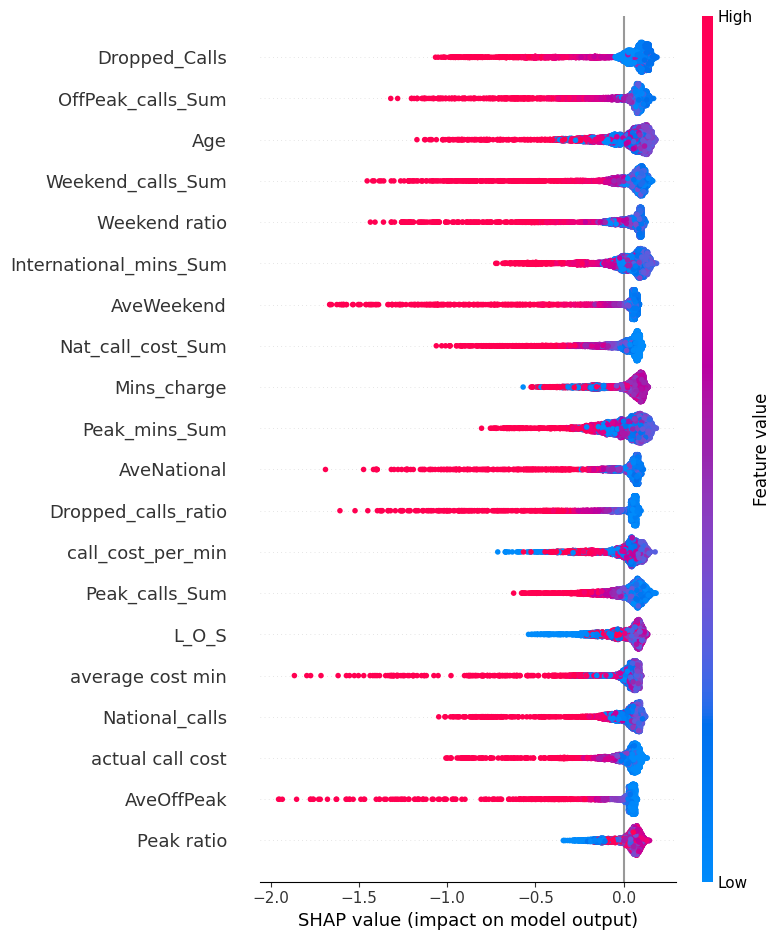

In [14]:
# https://stats.stackexchange.com/questions/404017/how-to-get-top-features-that-contribute-to-anomalies-in-isolation-forest
import shap

# Create shap values and plot them
shap_values = shap.TreeExplainer(iso_forest).shap_values(outlier_df)
shap.summary_plot(shap_values, outlier_df)

In [15]:
# Decide or not to keep/drop/use the outliers as a feature. To research on churn context

**Modelling**

In [16]:
X = train_data.drop(columns=TARGET_VAR)
y = train_data[TARGET_VAR] 

NUM_VARS = train_data.select_dtypes(include='number').drop(columns=TARGET_VAR).columns
CAT_VARS = train_data.select_dtypes(include='object').columns

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

# Define preprocessors for numerical and categorical features
numerical_preprocessor = Pipeline([
    ("scaler", StandardScaler())
])

categorical_preprocessor = Pipeline([
    ("onehot", OneHotEncoder(drop="if_binary"))
])

In [18]:
# Combine preprocessors and model
model = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("numerical", numerical_preprocessor, NUM_VARS),
        ("categorical", categorical_preprocessor, CAT_VARS)
    ])),
    ("model", SVC(probability=True, random_state=SEED))
])


In [19]:
# For SVM
parameters = {'model__kernel':['linear', 'rbf'], 
              'model__C':[1]} # rmb to add the double underscores to allow gridsearch to fit on pipelines
svc_gs_est = GridSearchCV(estimator=model, param_grid=parameters,cv=KFOLD,
                      scoring="roc_auc",n_jobs=-1, refit=True)
svc_gs_est.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'L_O_S', 'Dropped_Calls', 'Peak_calls_Sum', 'Peak_mins_Sum',
       'OffPeak_calls_Sum', 'OffPeak_mins_Sum', 'Weekend_calls_Sum',
       'Weekend_mins_Sum', 'International_mins_Sum', 'Nat_call_cost_Sum',
       'AvePe...
       'OffPeak ratio', 'Weekend ratio', 'Nat-InterNat Ratio'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         Index(['Gender', 'tariff', 'Handset', 'Usage_Band', 'Tariff_OK',
       'high Dropped calls', 'No Usage'],
      dtype='object'))])),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [1], 'model__kernel': ['linear', 'rbf']},
             scoring='roc_auc')

In [20]:
svc_gs_results = pd.DataFrame(data=svc_gs_est.cv_results_)
svc_gs_results.sort_values(by='rank_test_score', ascending = True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,3.258041,0.705735,0.200098,0.045221,1,rbf,"{'model__C': 1, 'model__kernel': 'rbf'}",0.936874,0.903418,0.909888,0.940346,0.905075,0.919120,0.016092,1
0,4.587256,1.277925,0.073309,0.037441,1,linear,"{'model__C': 1, 'model__kernel': 'linear'}",0.905346,0.908717,0.902435,0.911292,0.910740,0.907706,0.003360,2


In [21]:
# Interpretability

**Prediction**

In [22]:
# Retrain best model: Set up the params accordingly
numerical_preprocessor = Pipeline([
    ("scaler", StandardScaler())
])

categorical_preprocessor = Pipeline([
    ("onehot", OneHotEncoder(drop="if_binary"))
])

best_model = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("numerical", numerical_preprocessor, NUM_VARS),
        ("categorical", categorical_preprocessor, CAT_VARS)
    ])),
    ("model", SVC(probability=True, random_state=SEED, C=1, kernel="rbf"))
])


best_model.fit(X, y)
pred = pd.DataFrame(best_model.predict_proba(test_data), 
                    columns=["0", "1"])

In [23]:
# For submission
test_data_sub = pd.DataFrame(data={'ID':test_data['id'], 
                                   'PRED':pred["1"]})
test_data_sub

,ID,PRED
0,K751808,0.041132
1,K837351,0.040839
2,K548114,0.059575
3,K736156,0.040866
4,K508080,0.040395
...,...,...
1677,K588314,0.043659
1678,K826807,0.062479
1679,K982731,0.061769
1680,K623037,0.044050


**XGBoost**

In [24]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

In [25]:
# Basic preprocessing
numeric_transformer = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_transformer = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUM_VARS),
        ("cat", categorical_transformer, CAT_VARS),
    ]
)

X = preprocessor.fit_transform(X)
# Alternatively split train-test before, do preprocessing on training data (fit_transform) then transform test data


In [26]:
X_train, X_test, y_train, y_test= train_test_split(X, y,
test_size=0.2, random_state=420)

Grid search

In [27]:
# First do a random search over a large hyperparameter space, trying 1000 random models 
gbm_param_grid_large = {  'n_estimators': np.arange(5, 101, 1)
                        , 'max_depth': range(2, 13)
                        , 'learning_rate': np.arange(0.001, 5, 0.01)
                        , 'subsample': [0.2, 0.4, 0.6, 0.8, 1]
                        , 'colsample_bytree': [0.2, 0.5, 0.8, 1]
                        , 'reg_lambda': [0, 1, 5, 10, 100]
                        }

gbm = xgb.XGBClassifier(random_state=420)
randomized_auc = RandomizedSearchCV(  estimator=gbm
                                    , param_distributions=gbm_param_grid_large
                                    , n_iter=1000
                                    , scoring='roc_auc'
                                    , cv=5
                                    , n_jobs=-1
                                    , verbose=1
                                    , random_state=420)

# See how the cross-validation performed (on the "training" data) and the best tuned hyperparameter values
randomized_auc.fit(X_train, y_train)
print("Best parameters found: ",randomized_auc.best_params_)
print("Lowest AUC found: ", randomized_auc.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best parameters found:  {'subsample': 1, 'reg_lambda': 0, 'n_estimators': 89, 'max_depth': 11, 'learning_rate': 0.20099999999999996, 'colsample_bytree': 0.8}
Lowest AUC found:  0.9346962870153964


In [46]:
# Now do another random search over a smaller hyperparameter space around the preivously found "best" values
gbm_param_grid_medium = {  'n_estimators': np.arange(80, 120, 1)
                         , 'max_depth': range(8, 16)
                         , 'learning_rate': np.arange(0.05, 5.05, 0.05)
                         , 'subsample': [0.6, 0.8, 1]
                         , 'colsample_bytree': [0.5, 0.8, 1]
                         , 'reg_lambda': [0, 1, 2, 5]
                         }

gbm = xgb.XGBClassifier(random_state=420)
randomized_auc = RandomizedSearchCV(  estimator=gbm
                                    , param_distributions=gbm_param_grid_medium
                                    , n_iter=1000
                                    , scoring='roc_auc'
                                    , cv=5
                                    , n_jobs=-1
                                    , verbose=1
                                    , random_state=420)

# See how the cross-validation performed (on the "training" data) and the best tuned hyperparameter values
randomized_auc.fit(X_train, y_train)
print("Best parameters found: ",randomized_auc.best_params_)
print("Lowest AUC found: ", randomized_auc.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best parameters found:  {'subsample': 1, 'reg_lambda': 0, 'n_estimators': 111, 'max_depth': 8, 'learning_rate': 0.15000000000000002, 'colsample_bytree': 0.8}
Lowest AUC found:  0.9369925065657905


In [27]:
# We got quite different reults, but different hyperparameter combinations can give similar results.
# Finally a grid-search that is not random around the previous "best" values.
gbm_param_grid = {  'n_estimators': [90, 100, 110, 120]
                  , 'max_depth': [8, 10, 12]
                  , 'learning_rate': [0.1, 0.15, 0.2, 0.25]
                  , 'subsample': [0.8, 1]
                  , 'colsample_bytree': [0.7, 0.8, 0.9]
                  , 'reg_lambda': [0, 1, 2]
                  }

gbm = xgb.XGBClassifier(random_state=420)
grid_auc = GridSearchCV(  estimator=gbm
                        , param_grid=gbm_param_grid
                        , scoring='roc_auc'
                        , cv=5
                        , n_jobs=-1
                        , verbose=1
                        )

# See how the cross-validation performed (on the "training" data) and the best tuned hyperparameter values
grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Lowest AUC found: ", grid_auc.best_score_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 90, 'reg_lambda': 0, 'subsample': 1}
Lowest AUC found:  0.9382550658988507


In [41]:
# Get an idea about how the model performs on the test set
predicted_labels = grid_auc.predict(X_test)
auc_score = roc_auc_score(y_test, predicted_labels)
auc_score
# This is much less than on the training set so the model probably overfits the training data...

0.8595840867992767

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=90, n_jobs=None,
              num_parallel_tree=None, random_state=420, ...)

In [47]:
# Re-train the tuned model (even though its overfitted) on the entire training data (not just on the 80% of it)
best_xgb = grid_auc.best_estimator_
best_xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=90, n_jobs=None,
              num_parallel_tree=None, random_state=420, ...)

All in one - pipeline, xgboost with gridsearch